# Men's NCAA Basketball Tournament Predictions

## Download data from Kaggle

I used the Kaggle API to download the data. This requires an account in order to obtain an API key and to accept the terms and conditions of the [Google Cloud & Men's 2019 NCAA Tournament ML Competition](https://www.kaggle.com/c/mens-machine-learning-competition-2019/).

In [150]:
%%bash
kaggle competitions download -c mens-machine-learning-competition-2019

SampleSubmissionStage1.csv: Skipping, found more recently modified local copy (use --force to force download)













100%|██████████| 13.7M/13.7M [00:03<00:00, 5.51MB/s]
100%|██████████| 19.9M/19.9M [00:03<00:00, 5.96MB/s]
100%|██████████| 20.0M/20.0M [00:04<00:00, 5.08MB/s]
100%|██████████| 19.9M/19.9M [00:04<00:00, 4.50MB/s]
100%|██████████| 20.3M/20.3M [00:03<00:00, 5.38MB/s]
100%|██████████| 21.0M/21.0M [00:04<00:00, 5.34MB/s]
100%|██████████| 20.4M/20.4M [00:04<00:00, 5.20MB/s]
100%|██████████| 21.2M/21.2M [00:03<00:00, 6.00MB/s]
100%|██████████| 20.5M/20.5M [00:04<00:00, 4.71MB/s]
100%|██████████| 20.6M/20.6M [00:04<00:00, 4.58MB/s]
100%|██████████| 4.25M/4.25M [00:00<00:00, 4.56MB/s]


We care mostly about the files in ```DataFiles.zip```, so we will only unzip this directory. All the others contain information about play-by-play events. It would be really cool to incorporate individual player stats into a ML algorithm, but for now, I will only use team stats for each individual game.

In [151]:
import zipfile
zip_ref = zipfile.ZipFile('DataFiles.zip', 'r')
zip_ref.extractall('DataFiles')
zip_ref.close()

I like to use Pandas to work with tabular data. There are two types of game-by-game data for the NCAA: compact results which give the simple box scores for each game (teamIDs, scores, and who was the home team or if the game was played at a neutral site) and detailed results with box scores along with all the statisics like field goal attempts/completions, etc. The former goes back all the way to 1985 and the latter only to 2003. We can use all the box scores dating back from 1985 to establish a long enough baseline to determine accurage Elo scores.

In [601]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('DataFiles/RegularSeasonCompactResults.csv')
df1['Playoff'] = 0
df2 = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
df2['Playoff'] = 1
df = pd.concat([df1,df2])

In [602]:
df = df.sort_values(by=['Season','DayNum'])

In [603]:
df['WProb_Elo'] = np.nan

In [604]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Playoff,WProb_Elo
0,1985,20,1228,81,1328,64,N,0,0,NaN
1,1985,25,1106,77,1354,70,H,0,0,NaN
2,1985,25,1112,63,1223,56,H,0,0,NaN
3,1985,25,1165,70,1432,54,H,0,0,NaN
4,1985,25,1192,86,1447,74,H,0,0,NaN


Elo scores were first developed for chess but have been adopted to predict outcomes of other games and sports. I have chosen to use the NBA Elo scores developed by [FiveThirtyEight](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/).

We can calculate the probability of winning based on the Elo score difference between any two teams.

In [605]:
def elo_prob(eloW,eloL,locW):
    if locW == 'H':
        value = HCA
    elif locW == 'A':
        value = -HCA
    else:
        value = 0
        
    elo_diff = eloW-eloL+value
        
    probW = 1 / (10**(-elo_diff/400) + 1)
    return probW

Elo scores are updated after a game occurs based on how surprising the outcome is. The larger the difference in the scores, the larger the expected point spread is. If the actual point differential is larger than expected, the more the Elo scores change. Elo scores are a zero-sum game, so points are added to the team who beats the point spread while points are taken from the other team.

In [606]:
def update_elo(eloW,ptsW,eloL,ptsL,locW):
    if locW == 'H':
        value = HCA
    elif locW == 'A':
        value = -HCA
    else:
        value = 0
        
    MOV = ptsW-ptsL
    elo_diff = eloW-eloL+value
    
    mult = (MOV+3)**0.8 / (7.5 + 0.006*elo_diff)
    probW = elo_prob(eloW,eloL,locW)
    
    shift = K*mult*(1-probW)
    
    return eloW + shift, eloL - shift

At the end of the season, the Elo scores revert back toward the mean of 1500.

In [607]:
def season_revert(team_elo):
    for team,elo in team_elo.items():
        team_elo[team] = 1505*R + elo*(1-R)
    return team_elo

Not all the teams have been Division 1 since 1985, so we will have to add in the new teams at the beginning of the season. For that, we will need the data file indicating their first D1 season. Every team's first D1 season (starting with 1985) will have an Elo score of 1300. The next block of code propagates the Elo scores in chronological order.

In [612]:
def forecast(df):
    team_elo = {t:ELO_START for t in df['WTeamID'].unique()}
    season = 1985
    for i,game in df.iterrows():
        
        if game['Season'] > season:
            team_elo = season_revert(team_elo)
            season = game['Season']
        
        teamW = game['WTeamID']
        ptsW = game['WScore']
        eloW = team_elo[teamW]
        
        teamL = game['LTeamID']
        ptsL = game['LScore']
        eloL = team_elo[teamL]
        
        locW = game['WLoc']
    
        df.at[i,'WElo'] = eloW
        df.at[i,'LElo'] = eloL
    
        df.at[i,'WProb_Elo'] = elo_prob(eloW,eloL,locW)
        
        eloW,eloL = update_elo(eloW,ptsW,eloL,ptsL,locW)
        team_elo[teamW] = eloW
        team_elo[teamL] = eloL
        
    return df

Next: find a way to use the multiprocessing module to search the entire parameter grid for best score and sumprob.

In [ ]:
def grid_search_elo(df,param_grid):
    

In [613]:
import time

k = [20,30,40]
hca=[50,100,150]
r=[1/5,1/4,1/3]
elo_start = [1200,1300,1400]

results = []
count = 1
total = len(k)*len(hca)*len(r)*len(elo_start)

for K in k:
    for HCA in hca:
        for R in r:
            for ELO_START in elo_start:
                start = time.time()
                df_iter = forecast(df)
                end = time.time()
                dt = end-start
                est_end = (total-count)*dt/60
                    
                score = (df_iter['WProb_Elo'] > 0.5).sum()/len(df_iter)
                sumprob = df_iter['WProb_Elo'].sum()/len(df_iter)
                print('%d/%d...K=%d,HCA=%d,R=%0.2f: score = %0.3f, sumprob = %0.3f...dt=%0.1fs...est_remaining=%0.1fmin' % \
                      (count,total,K,HCA,R,score,sumprob,dt,est_end))
                    
                results.append({'K':K,'HCA':HCA,'R':R,'score':score,'sumprob':sumprob})
                count += 1

1/81...K=20,HCA=50,R=0.20: score = 0.728, sumprob = 0.608...dt=58.6s...est_remaining=78.1min
2/81...K=20,HCA=50,R=0.20: score = 0.728, sumprob = 0.608...dt=60.6s...est_remaining=79.8min
3/81...K=20,HCA=50,R=0.20: score = 0.728, sumprob = 0.608...dt=58.0s...est_remaining=75.4min
4/81...K=20,HCA=50,R=0.25: score = 0.730, sumprob = 0.604...dt=63.6s...est_remaining=81.6min
5/81...K=20,HCA=50,R=0.25: score = 0.730, sumprob = 0.604...dt=60.0s...est_remaining=76.0min
6/81...K=20,HCA=50,R=0.25: score = 0.730, sumprob = 0.604...dt=60.1s...est_remaining=75.1min
7/81...K=20,HCA=50,R=0.33: score = 0.732, sumprob = 0.598...dt=60.4s...est_remaining=74.5min
8/81...K=20,HCA=50,R=0.33: score = 0.732, sumprob = 0.598...dt=60.4s...est_remaining=73.5min
9/81...K=20,HCA=50,R=0.33: score = 0.732, sumprob = 0.598...dt=60.3s...est_remaining=72.3min
10/81...K=20,HCA=100,R=0.20: score = 0.730, sumprob = 0.620...dt=59.9s...est_remaining=70.9min
11/81...K=20,HCA=100,R=0.20: score = 0.730, sumprob = 0.620...dt=60.

KeyboardInterrupt: 

How well does Elo do on its own? One way to check would be to see how many times the Elo scores accurately predict a single game. We can say that if the probability that the winning team would win given the Elo scores of both teams is greater than 50%, then we would have been correct. Here's how we compute the percentage of games we got correct.

In [597]:
dt = 1.000
est_end = 100.00
count = 1
total = 
print('%d/%d...K=%d,HCA=%d,R=%0.2f: score = %0.3f, sumprob = %0.3f...dt=%0.1fs...est_remaining=%0.1fmin' % \
                      (count,total,K,HCA,R,score,sumprob,dt,est_end))

TypeError: %d format: a number is required, not list

In [395]:
(df['WProb_Elo'] > 0.5).sum()/len(df)

0.7294168935952436

But what if we are really off in our prediction? Obviously, if we predicted 10% for the winning team to win, that would be bad. We then could add up all the probabilities and see how close we get to the total number of games.

In [396]:
df['WProb_Elo'].sum()/len(df)

0.61071068694896

## Game statistics

In [533]:
data1 = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
data1['Playoff'] = 0
data2 = pd.read_csv('DataFiles/NCAATourneyDetailedResults.csv')
data2['Playoff'] = 1
data = pd.concat([data1,data2])
data = data.sort_values(by=['Season','DayNum'])

In [534]:
data.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Playoff
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,0
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,0
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,0
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,0
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,0
5,2003,11,1458,81,1186,55,H,0,26,57,...,12,17,6,22,8,19,4,3,25,0
6,2003,12,1161,80,1236,62,H,0,23,55,...,20,28,9,21,11,30,10,4,28,0
7,2003,12,1186,75,1457,61,N,0,28,62,...,17,23,8,25,10,15,14,8,18,0
8,2003,12,1194,71,1156,66,N,0,28,58,...,12,27,13,26,13,25,8,2,18,0
9,2003,12,1458,84,1296,56,H,0,32,67,...,7,12,9,23,10,18,1,3,18,0


In [520]:
data.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Playoff'],
      dtype='object')

Here are the statistics for each game since 2003.
- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

And the same for the losing teams with an "L" in front.

Let's append the Elo scores and probabilities to this new table.

In [552]:
df_short = df[df['Season'] >= 2003].reset_index(drop=True)
data = pd.merge(df_short,data)

Right now, the Elo scores are a good measure of the historical performance of a basketball program; however, game stats will help us to determine how a team has been performing as of late. We'll do this by taking a rolling average of some of the statistics over previous games. We have to be careful to not include the current game stats in this average because it will help to reveal the outcome of the game, which we are trying to predict.

In [553]:
## Here are the statistics we want to create rolling means for
to_roll = ['FGM','FGA','FGM3','FGA3']

## We're going to create a dictionary of dictionaries that store the rolling means for each team.
##    The outer dictionary is for each individual team.
##    The inner dictionaries contain each statistic's rolling mean.
averages = dict()
for ID in data['WTeamID'].unique():
    averages[ID] = dict()
    team = data[(data['WTeamID'] == ID) | (data['LTeamID'] == ID)]
    for r in to_roll:
        ## Here we apply a function that selects the correct statistic based on whether the team is W or L.
        ## Method chaining: roll over last 4 games, take the mean, shift one down so that we don't include
        ##     the statistic for the game that is being predicted, backward fill for NaN
        averages[ID][r] = team.apply(lambda x: x['W%s' % r] if x['WTeamID'] == 1104 else x['L%s' % r],axis=1).\
            rolling(4).mean().shift(1).bfill()

The predictors we use for our comprehensive algorithm will be the ratio of the winning team's statistic to that the losing team.

In [556]:
for r in to_roll:
    win = data.apply(lambda row: averages[row['WTeamID']][r].loc[row.name],axis=1)
    los = data.apply(lambda row: averages[row['LTeamID']][r].loc[row.name],axis=1)
    data[r] = win/los

## Prepping for ML

The data came to us without a "target" value, as the first team listed is always the winning team, we have to create our own. One way would be to randomly split the data in two and for half the data swap the teams. If the winning team is in the first column, the target is 1, or else it is 0. Of course, in doing this, we also have to reverse the predictor values to reflect the change.

In [557]:
## shuffle the data by re-sampling all of it
data_shuffle = data.sample(frac=1,random_state=123)

## split the shuffled data in two
orig = data_shuffle.iloc[:len(data)//2,:]
rev = data_shuffle.iloc[len(data)//2:,:]

## reverse the values in the second half of the data
for r in to_roll:
    temp = 1/rev[r]
    rev = rev.drop(columns=r)
    rev[r] = temp
new_prob = 1-rev['WProb_Elo']
rev = rev.drop(columns=['WProb_Elo'])
new_prob.head()
rev['WProb_Elo'] = new_prob

## order columns in rev
rev = rev[orig.columns]
orig = orig[orig.columns]

## Add columns for the target values
orig['result'] = 1
rev['result'] = 0

## Merge the two back together
data_target = pd.concat([orig,rev])
data_target.columns = data_target.columns.str.replace('WProb','Prob')
data_target = data_target.sort_values(by=['Season','DayNum'])

In [559]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83089 entries, 1 to 83088
Data columns (total 43 columns):
Season      83089 non-null int64
DayNum      83089 non-null int64
WTeamID     83089 non-null int64
WScore      83089 non-null int64
LTeamID     83089 non-null int64
LScore      83089 non-null int64
WLoc        83089 non-null object
NumOT       83089 non-null int64
Playoff     83089 non-null int64
Prob_Elo    83089 non-null float64
WElo        83089 non-null float64
LElo        83089 non-null float64
WFGM        83089 non-null int64
WFGA        83089 non-null int64
WFGM3       83089 non-null int64
WFGA3       83089 non-null int64
WFTM        83089 non-null int64
WFTA        83089 non-null int64
WOR         83089 non-null int64
WDR         83089 non-null int64
WAst        83089 non-null int64
WTO         83089 non-null int64
WStl        83089 non-null int64
WBlk        83089 non-null int64
WPF         83089 non-null int64
LFGM        83089 non-null int64
LFGA        83089 non-null

In [560]:
predictors = to_roll + ['Prob_Elo']

In [561]:
X = data_target[predictors]
y = data_target['result']

In [563]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

In [564]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(GradientBoostingClassifier(random_state=123),
                   param_grid = {'n_estimators':[100,200,300],
                                'min_samples_split':[2,3,4],
                                'max_depth':[3,4,5]})
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300], 'min_samples_split': [2, 3, 4], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [565]:
clf = grid.best_estimator_

In [566]:
print('Train score: %0.2f' % clf.score(X_train,y_train))
print('Test score:  %0.2f' % clf.score(X_test,y_test))

Train score: 0.73
Test score:  0.72


In [568]:
clf.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 123,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

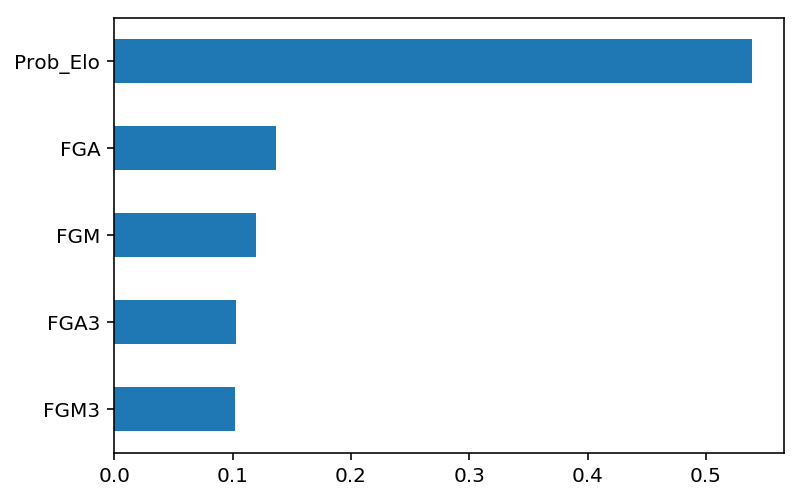

In [576]:
%matplotlib inline
pd.DataFrame(clf.feature_importances_,index=X.columns).sort_values(by=0).plot(kind='barh',legend=False)